# Import Modules


In [1]:
from google.colab import drive  # Access Google Drive in Google Colab
from google.colab import files  # Upload and download files in Colab
import zipfile  # Handle zip files
import shutil  # File and directory operations, like deletion or moving
import os  # Interact with the operating system
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob as gb
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

#Import dan unzip dataset

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to file ZIP in Google Drive
zip_path = '/content/drive/MyDrive/dataset/New-Bangladeshi-Crop-Disease.zip'

Mounted at /content/drive


In [3]:
# Extract zip file
! unzip '/content/drive/MyDrive/dataset/New-Bangladeshi-Crop-Disease.zip' -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice/Rice___Neck_Blast/IMG20201109203041_00.jpg  
  inflating: ./BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice/Rice___Neck_Blast/IMG20201109203044_00.jpg  
  inflating: ./BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice/Rice___Neck_Blast/IMG20201109203053_00.jpg  
  inflating: ./BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice/Rice___Neck_Blast/IMG20201109203056_00.jpg  
  inflating: ./BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice/Rice___Neck_Blast/IMG20201109203100_00.jpg  
  inflating: ./BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice/Rice___Neck_Blast/IMG20201109203104_00.jpg  
  inflating: ./BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice/Rice___Neck_Blast/IMG20201109203107_00.jpg  
  inflating: ./BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice/Rice___Neck_Blast/IMG20201109203111_00.jpg  
  inflating: ./BangladeshiCrops/Bangl

#EDA

di tahap ini kita akan mengetahui pesebaran data serta mengidentifikasi tahap selanjutnya

In [4]:
path_corn = '/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn' #Path ke directory file penyakit jagung
corn_classes = os.listdir(path_corn) #List kelas penyakit jagung
print(corn_classes)

['Corn___Common_Rust', 'Corn___Northern_Leaf_Blight', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy']



Corn___Common_Rust
Total Images: 1192
Resolution of First Image: (256, 256, 3)


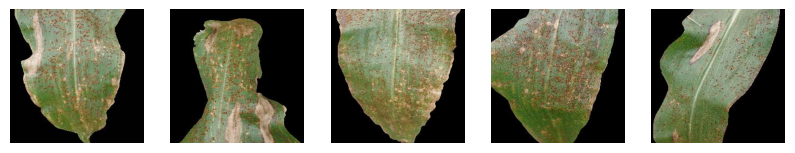


Corn___Northern_Leaf_Blight
Total Images: 985
Resolution of First Image: (256, 256, 3)


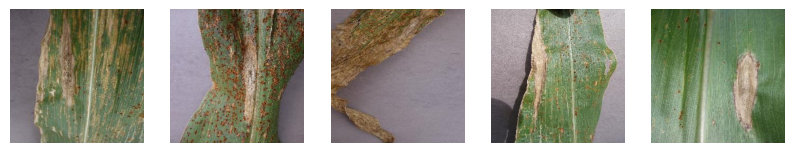


Corn___Gray_Leaf_Spot
Total Images: 513
Resolution of First Image: (256, 256, 3)


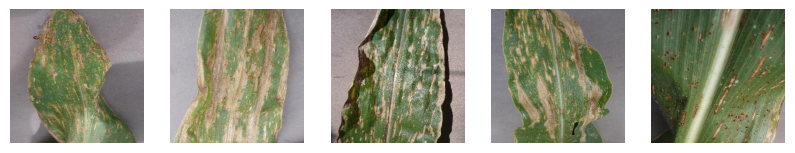


Corn___Healthy
Total Images: 1162
Resolution of First Image: (256, 256, 3)


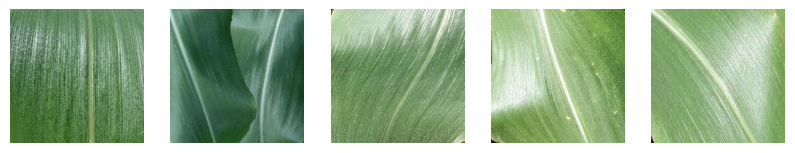

In [5]:
import matplotlib.image as mpimg
for item in corn_classes:
  print("")
  print(item)
  class_dir = os.path.join(path_corn, item)
  class_images = os.listdir(class_dir)

  # Total images in each classes
  num_images = len(class_images)
  print("Total Images:", num_images)

  # Resolution/size of each first image in class
  img_path = os.path.join(class_dir, class_images[0])
  img = mpimg.imread(img_path)
  image_shape = img.shape
  print("Resolution of First Image:", image_shape)

  # Showing some images
  plt.figure(figsize=(10, 5))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

terlihat bahwa terdapat ketidakseimbangan pada data tiap kategori. Hal ini tentunya akan mempengaruhi performa model.

#Data pre-processing

**image augmentation**

mula-mula, untuk menyeimbangkan pesebaran data, akan kita lakukan image augmentation.

disini kita augmentasi data yang kurang dulu, yaitu Corn___Northern_Leaf_Blight dan Corn___Gray_Leaf_Spot.

kita akan buat data pada semua kelas berjumlah 1160

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# augmentasi data Northern_Leaf_Blight
# Define the image data generator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    fill_mode='constant',     # Change to constant fill mode
    cval=0,
    brightness_range=[0.5, 1.5],  # adjust brightness
    width_shift_range=0.2,          # horizontal shift
    height_shift_range=0.2
)

# Path to your images
input_dir = '/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Northern_Leaf_Blight'  # Change this to your directory path
output_dir = '/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Northern_Leaf_Blight'  # Same as input_dir to save in the same directory

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List all files in the directory
image_files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

# Number of augmentations to create per image
num_augmentations = 1

# Process each image file
for image_file in image_files:
    # Load the image
    img_path = os.path.join(input_dir, image_file)
    img = load_img(img_path)
    x = img_to_array(img)  # Convert the image to a numpy array
    x = np.expand_dims(x, axis=0)  # Reshape it to (1, height, width, channels)

    # Generate augmentations
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= num_augmentations:  # Save a fixed number of augmentations per original image
            break

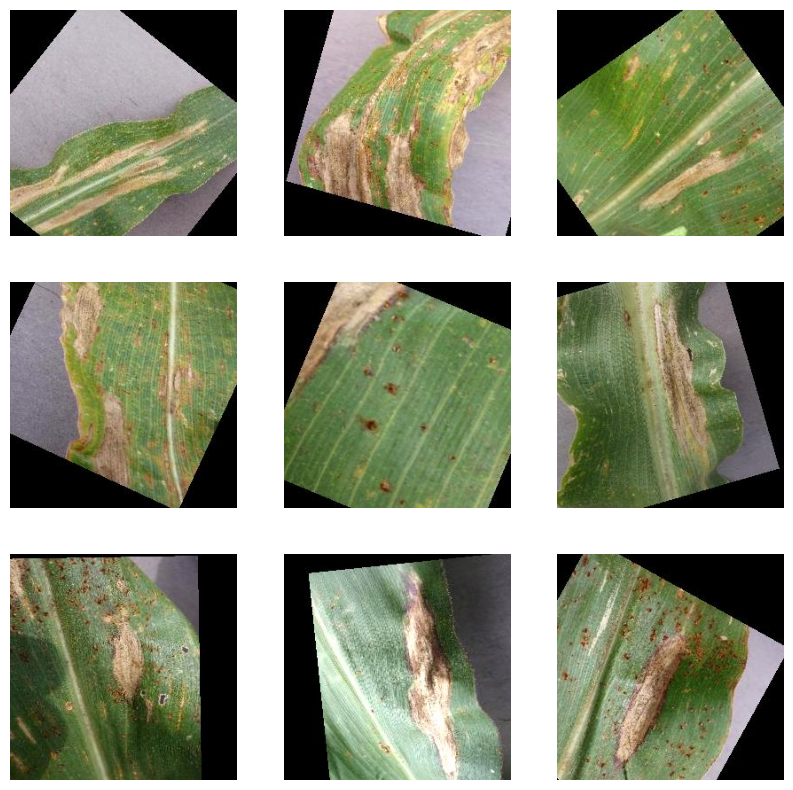

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#liat hasil augmentasi
# List files in the output directory
augmented_files = [f for f in os.listdir(output_dir) if 'aug' in f]

# Display some augmented images
num_images_to_display = 9
plt.figure(figsize=(10, 10))

for i in range(min(num_images_to_display, len(augmented_files))):
    plt.subplot(3, 3, i + 1)
    img = load_img(os.path.join(output_dir, augmented_files[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# augmentasi data gray leaf spot
# Define the image data generator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    fill_mode='constant',     # Change to constant fill mode
    cval=0,
    brightness_range=[0.5, 1.5],  # adjust brightness
    width_shift_range=0.2,          # horizontal shift
    height_shift_range=0.2
)

# Path to your images
input_dir = '/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Gray_Leaf_Spot'  # Change this to your directory path
output_dir = '/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Gray_Leaf_Spot'  # Same as input_dir to save in the same directory

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List all files in the directory
image_files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

# Number of augmentations to create per image
num_augmentations = 4

# Process each image file
for image_file in image_files:
    # Load the image
    img_path = os.path.join(input_dir, image_file)
    img = load_img(img_path)
    x = img_to_array(img)  # Convert the image to a numpy array
    x = np.expand_dims(x, axis=0)  # Reshape it to (1, height, width, channels)

    # Generate augmentations
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= num_augmentations:  # Save a fixed number of augmentations per original image
            break

Okay, karena augmentasi sudah berhasil

Kemudian kita harus membuat semua kelas berisi 1160 data agar tidak terjadi bias pada model

In [9]:
import random
def trim_dataset(base_dir, max_files_per_class=1160):
    for class_folder in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_folder)

        # Ensure we are working with directories only
        if os.path.isdir(class_path):
            # List all files in the class directory
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

            # Shuffle the files to ensure randomness
            random.shuffle(files)

            # If there are more files than max_files_per_class, delete the excess
            if len(files) > max_files_per_class:
                files_to_delete = files[max_files_per_class:]
                for file_name in files_to_delete:
                    file_path = os.path.join(class_path, file_name)
                    os.remove(file_path)
                    print(f"Removed: {file_path}")

# Path to the main folder containing class subfolders
base_dir = path_corn  # Change this to your directory path

# Trim the dataset
trim_dataset(base_dir)


Removed: /content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Common_Rust/image (579).JPG
Removed: /content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Common_Rust/image (68).JPG
Removed: /content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Common_Rust/image (508).JPG
Removed: /content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Common_Rust/image (411).JPG
Removed: /content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Common_Rust/image (681).JPG
Removed: /content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Common_Rust/image (677).JPG
Removed: /content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Common_Rust/image (529).JPG
Removed: /content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Common_Rust/image (275).JPG
Removed: /content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Common_Rust/image (930).JPG
Removed: /content/BangladeshiCrops/Ban

In [10]:
# Verify the result
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):
        num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        print(f"Class '{class_folder}' now has {num_files} images.")


Class 'Corn___Common_Rust' now has 1160 images.
Class 'Corn___Northern_Leaf_Blight' now has 1160 images.
Class 'Corn___Gray_Leaf_Spot' now has 1160 images.
Class 'Corn___Healthy' now has 1160 images.


now we got 1000 images for each classes

#labelling dan normalisasi data menggunakan ImageDataGenerator

Mula-mula, kita harus membuat directory untuk data training dan validation agar data dapat memiliki label sesuai dengan directory mereka disimpan

In [11]:
pip install split-folders


In [12]:
import splitfolders

# Define paths
input_folder = path_corn
output_folder = '/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/working'

# Split the dataset into train and validation
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 4640 files [00:03, 1486.59 files/s]


In [13]:
path_corn_train = '/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/working/train' #Path ke directory file penyakit jagung
path_corn_val = '/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/working/val'
path_corn_test = '/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/working/test'
corn_classes_train = os.listdir('/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/working/train') #List kelas penyakit jagung
corn_classes_val = os.listdir('/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/working/val') #List kelas penyakit jagung
corn_classes_test = os.listdir('/content/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/working/test') #List kelas penyakit jagung

print(corn_classes_train)
print(corn_classes_val)
print(corn_classes_test)

['Corn___Common_Rust', 'Corn___Northern_Leaf_Blight', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy']
['Corn___Common_Rust', 'Corn___Northern_Leaf_Blight', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy']
['Corn___Common_Rust', 'Corn___Northern_Leaf_Blight', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy']


## data training


Corn___Common_Rust
Total Images: 812
Resolution of First Image: (256, 256, 3)


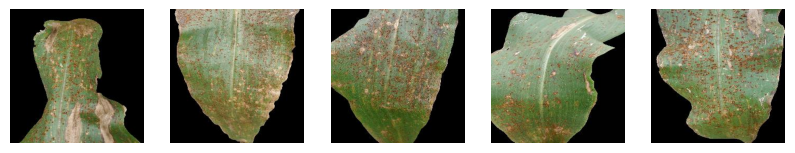


Corn___Northern_Leaf_Blight
Total Images: 812
Resolution of First Image: (256, 256, 3)


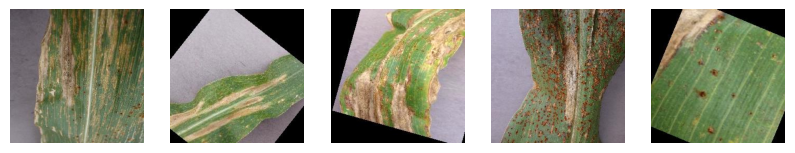


Corn___Gray_Leaf_Spot
Total Images: 812
Resolution of First Image: (256, 256, 3)


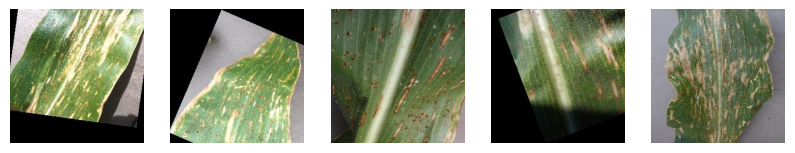


Corn___Healthy
Total Images: 812
Resolution of First Image: (256, 256, 3)


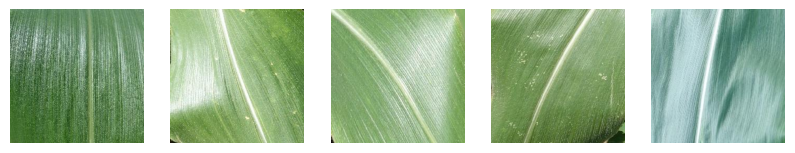

In [14]:
import matplotlib.image as mpimg
for item in corn_classes_train:
  print("")
  print(item)
  class_dir = os.path.join(path_corn_train, item)
  class_images = os.listdir(class_dir)

  # Total images in each classes
  num_images = len(class_images)
  print("Total Images:", num_images)

  # Resolution/size of each first image in class
  img_path = os.path.join(class_dir, class_images[0])
  img = mpimg.imread(img_path)
  image_shape = img.shape
  print("Resolution of First Image:", image_shape)

  # Showing some images
  plt.figure(figsize=(10, 5))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

## data validasi


Corn___Common_Rust
Total Images: 174
Resolution of First Image: (256, 256, 3)


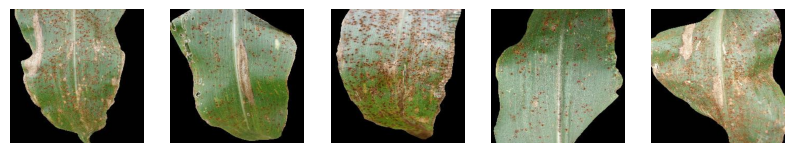


Corn___Northern_Leaf_Blight
Total Images: 174
Resolution of First Image: (256, 256, 3)


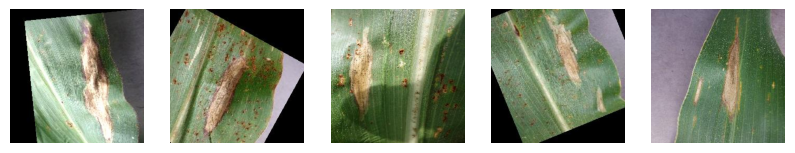


Corn___Gray_Leaf_Spot
Total Images: 174
Resolution of First Image: (256, 256, 3)


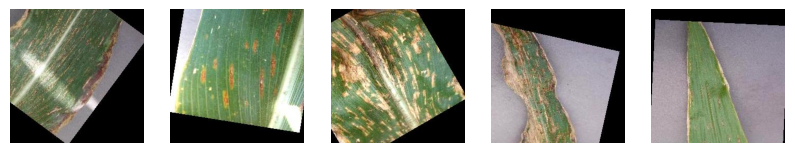


Corn___Healthy
Total Images: 174
Resolution of First Image: (256, 256, 3)


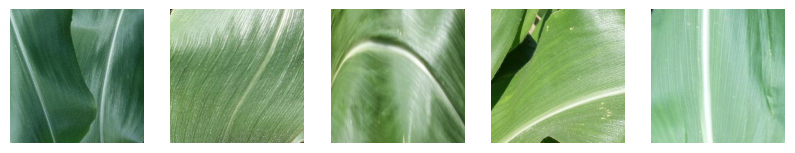

In [15]:
import matplotlib.image as mpimg
for item in corn_classes_val:
  print("")
  print(item)
  class_dir = os.path.join(path_corn_val, item)
  class_images = os.listdir(class_dir)

  # Total images in each classes
  num_images = len(class_images)
  print("Total Images:", num_images)

  # Resolution/size of each first image in class
  img_path = os.path.join(class_dir, class_images[0])
  img = mpimg.imread(img_path)
  image_shape = img.shape
  print("Resolution of First Image:", image_shape)

  # Showing some images
  plt.figure(figsize=(10, 5))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

## Data test


Corn___Common_Rust
Total Images: 174
Resolution of First Image: (256, 256, 3)


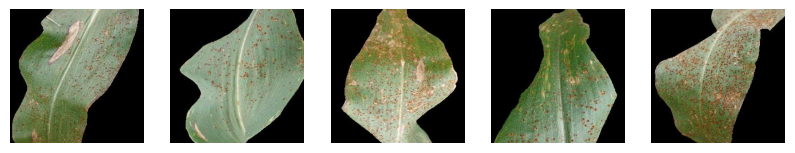


Corn___Northern_Leaf_Blight
Total Images: 174
Resolution of First Image: (256, 256, 3)


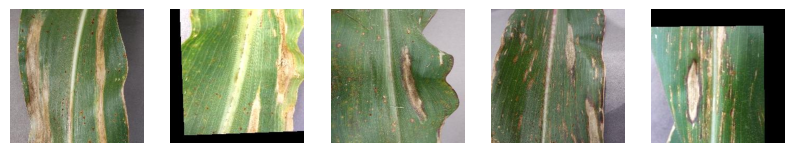


Corn___Gray_Leaf_Spot
Total Images: 174
Resolution of First Image: (256, 256, 3)


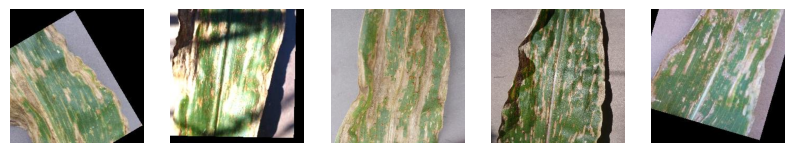


Corn___Healthy
Total Images: 174
Resolution of First Image: (256, 256, 3)


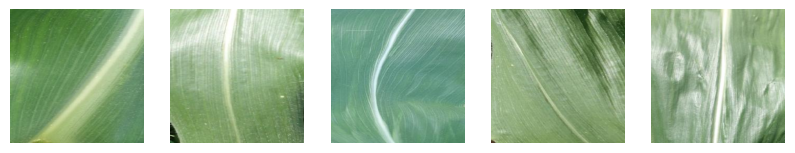

In [16]:
import matplotlib.image as mpimg
for item in corn_classes_val:
  print("")
  print(item)
  class_dir = os.path.join(path_corn_test, item)
  class_images = os.listdir(class_dir)

  # Total images in each classes
  num_images = len(class_images)
  print("Total Images:", num_images)

  # Resolution/size of each first image in class
  img_path = os.path.join(class_dir, class_images[0])
  img = mpimg.imread(img_path)
  image_shape = img.shape
  print("Resolution of First Image:", image_shape)

  # Showing some images
  plt.figure(figsize=(10, 5))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

In [17]:
#training and validation directories
train_dir = path_corn_train
validation_dir = path_corn_val
test_dir = path_corn_test

In [18]:
#import training data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   )

# YOUR IMAGE SIZE SHOULD BE 150x150
train_generator=  train_datagen.flow_from_directory(
        train_dir,
        target_size = (150,150),
        batch_size = 32,
        class_mode = 'categorical'
    )

#import validation data
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                        shear_range = 0.2,
                                        zoom_range = 0.2,
                                        )

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical'
    )

#import test data
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical'
    )

Found 3248 images belonging to 4 classes.
Found 696 images belonging to 4 classes.
Found 696 images belonging to 4 classes.


Training Data


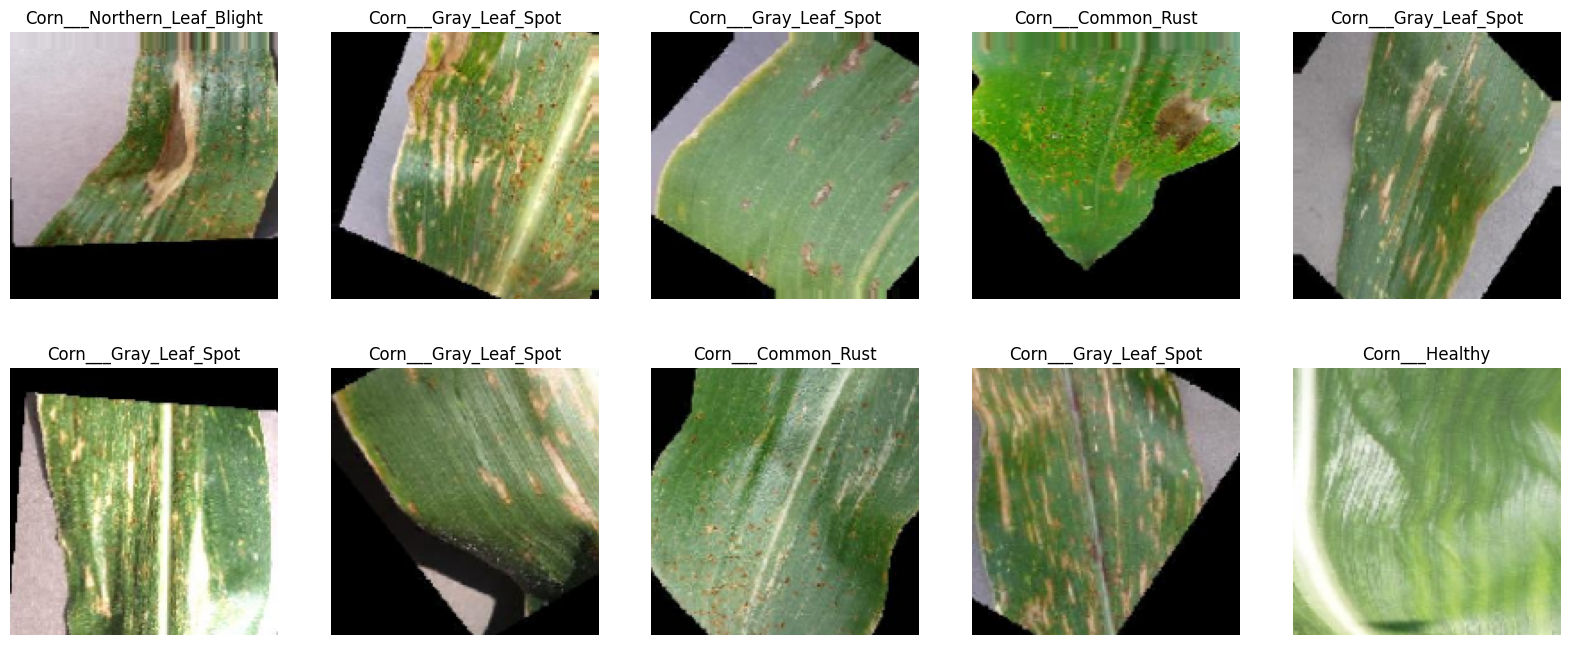

Validation Data


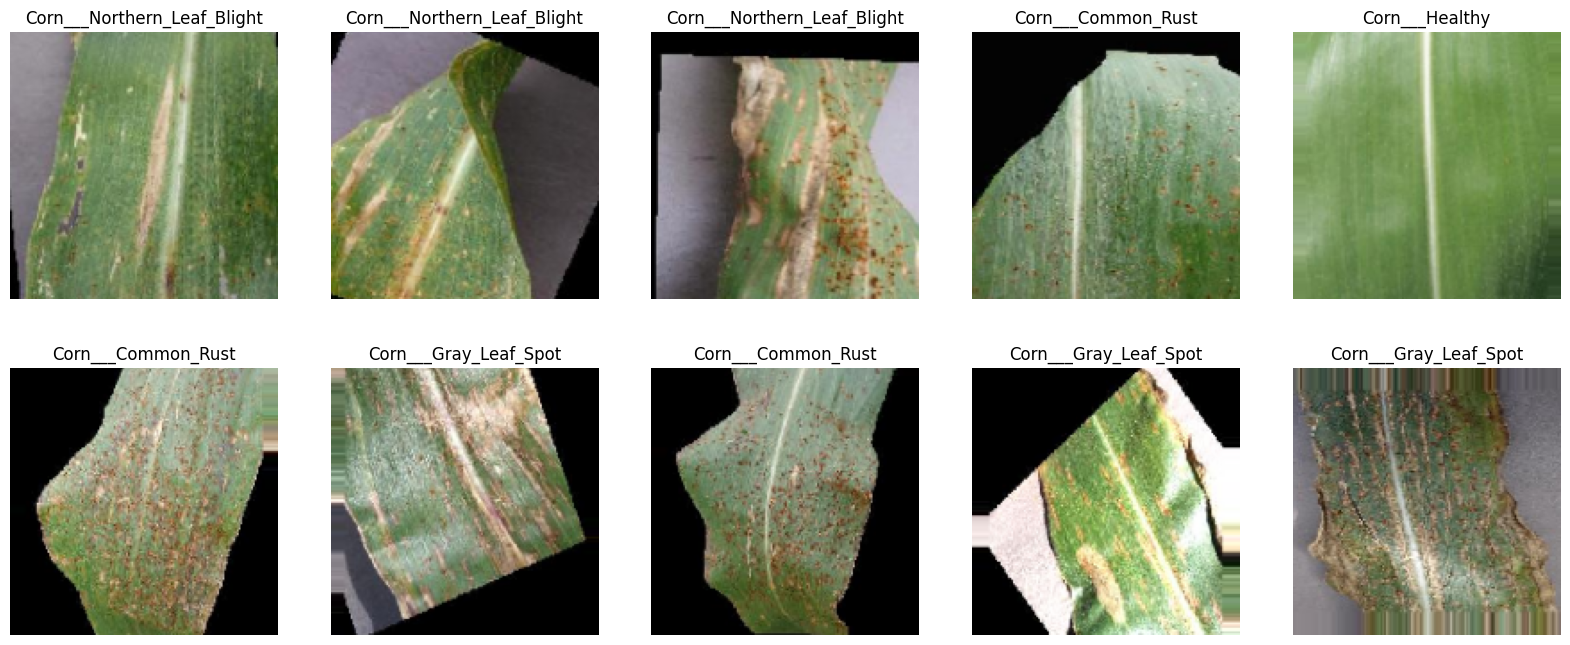

Test Data


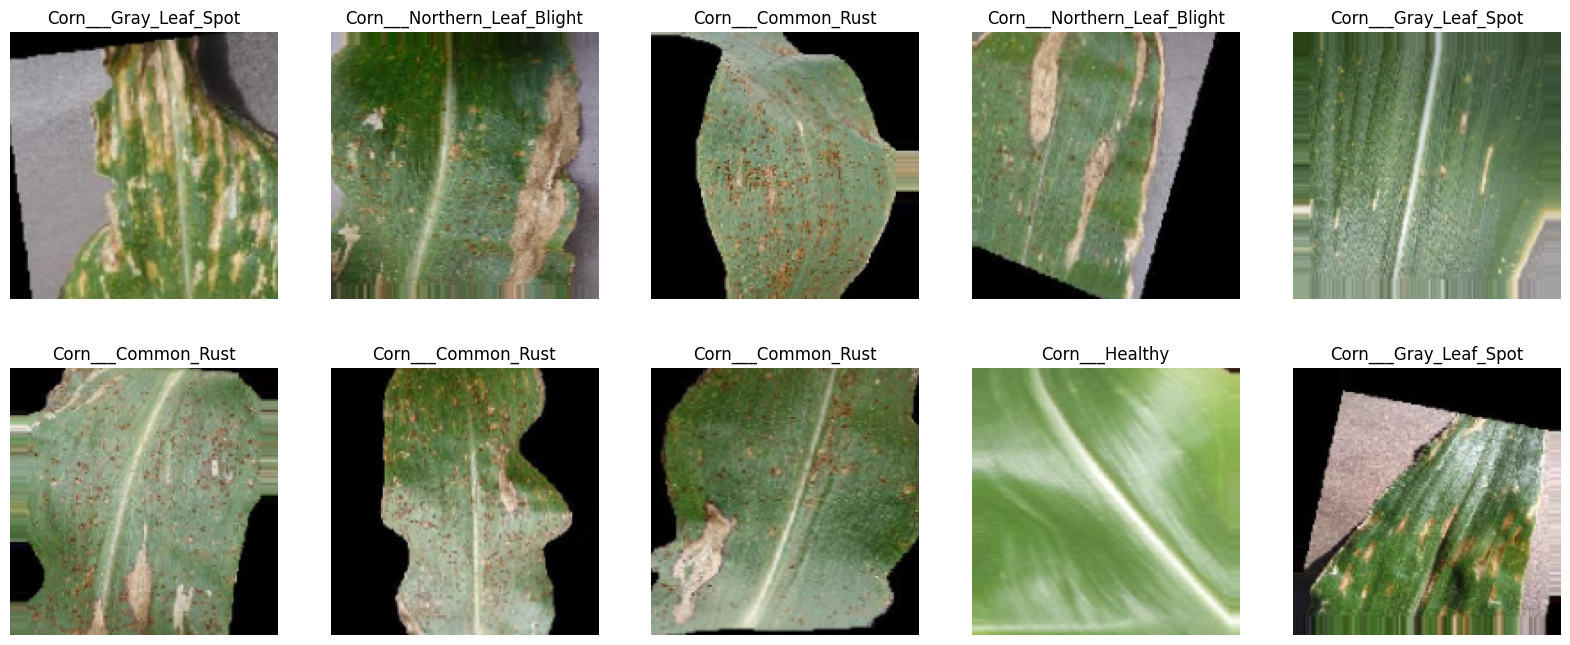

In [19]:
# Get class indices and invert the dictionary to get class labels
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Function to plot images with their labels
def plot_images(images, labels, idx_to_class, num_images=10):
    plt.figure(figsize=(20, 8))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        label_idx = np.argmax(labels[i])  # Get the index of the highest probability class
        plt.title(idx_to_class[label_idx])
    plt.show()

# Print a batch of training data
images, labels = next(train_generator)
print("Training Data")
plot_images(images, labels, idx_to_class)

# Print a batch of validation data
images, labels = next(validation_generator)
print("Validation Data")
plot_images(images, labels, idx_to_class)

# Print a batch of validation data
images, labels = next(test_generator)
print("Test Data")
plot_images(images, labels, idx_to_class)


In [20]:
!pip install requests


## Training data

Kita akan melakukan transfer learning untuk menggunakan arsitektur neural network yang sudah ada, yaitu InceptionV3. InceptionV3 sering kali digunakan pada aplikasi image classification.

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import urllib.request

In [22]:
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve( inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model =  InceptionV3(input_shape=(150, 150, 3),
                                 include_top=False, weights=None) # YOUR CODE HERE

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer =  pre_trained_model.get_layer('mixed7') # YOUR CODE HERE
last_output = last_layer.output


In [23]:
#last layers
x = Flatten()(last_output)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(4, activation='softmax')(x)

In [24]:
#pre-trained model
model = Model(pre_trained_model.input, x)

#compile model
model.compile(optimizer=RMSprop(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['acc'])

In [25]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('acc') > 0.93 and logs.get('val_acc') > 0.90):
                print("\n Accuracy is more than 95%, stopping...")
                self.model.stop_training = True

customCallback = myCallback()

In [26]:
history = model.fit(
        train_generator,
        validation_data=validation_generator,  # Added validation data here
        epochs=50,
        verbose=1,
        steps_per_epoch=40,
        callbacks=[customCallback]
        )

Epoch 1/50
40/40 [==============================] - 119s 3s/step - loss: 0.9036 - acc: 0.7047 - val_loss: 0.4436 - val_acc: 0.8032
Epoch 2/50
40/40 [==============================] - 105s 3s/step - loss: 0.4479 - acc: 0.8125 - val_loss: 0.2873 - val_acc: 0.8879
Epoch 3/50
40/40 [==============================] - 101s 3s/step - loss: 0.3427 - acc: 0.8547 - val_loss: 0.2376 - val_acc: 0.8980
Epoch 4/50
40/40 [==============================] - 106s 3s/step - loss: 0.3321 - acc: 0.8602 - val_loss: 0.3277 - val_acc: 0.8736
Epoch 5/50
40/40 [==============================] - 102s 3s/step - loss: 0.2924 - acc: 0.8836 - val_loss: 0.2281 - val_acc: 0.9009
Epoch 6/50
40/40 [==============================] - 95s 2s/step - loss: 0.2774 - acc: 0.8964 - val_loss: 0.2261 - val_acc: 0.9124
Epoch 7/50
40/40 [==============================] - 98s 2s/step - loss: 0.2671 - acc: 0.8984 - val_loss: 0.3333 - val_acc: 0.8851
Epoch 8/50
40/40 [==============================] - 108s 3s/step - loss: 0.2771 - acc

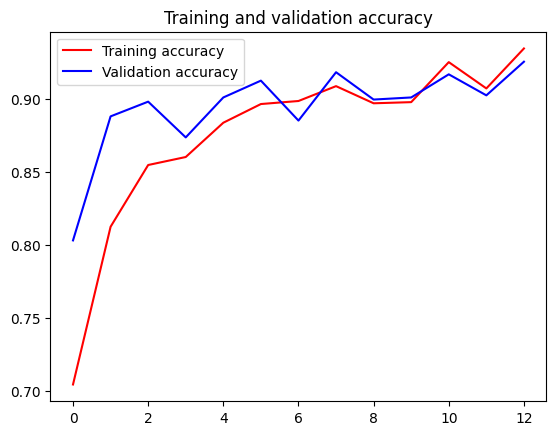

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [28]:
model.save("corn_inception_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("test Accuracy:", test_accuracy)

22/22 [==============================] - 33s 1s/step - loss: 0.1907 - acc: 0.9267
test Accuracy: 0.9267241358757019


Terlihat bahwa akurasi dari data test mencapai 92%

In [30]:
model_load = tf.keras.models.load_model('/content/corn_inception_model.h5', compile=False)


Saving WhatsApp Image 2024-06-07 at 9.34.00 PM.jpeg to WhatsApp Image 2024-06-07 at 9.34.00 PM.jpeg
1/1 [==============================] - 2s 2s/step

Predict:
common rust

Probablity:
Corn___Healthy : 0.00%
Corn___Gray_Leaf_Spot : 0.00%
Corn___Common_Rust : 100.00%
Corn___Northern_Leaf_Blight : 0.00%


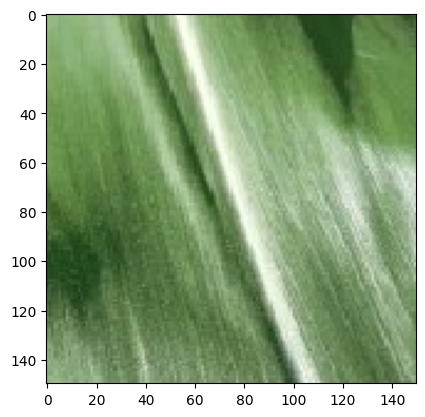

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files  # Only if you're using Google Colab or a similar environment

# get user image input
labels = ['Corn___Healthy', 'Corn___Gray_Leaf_Spot', 'Corn___Common_Rust', 'Corn___Northern_Leaf_Blight']

uploaded = files.upload()

for path in uploaded.keys():
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  images /= 255

  classes = model_load.predict(images, batch_size=32)
  predicted_class_indices=np.argmax(classes)


print("\nPredict:")
if predicted_class_indices == 0:
  print('healthy')
elif predicted_class_indices == 1:
  print('gray leaf spot')
elif predicted_class_indices == 2:
  print('common rust')
elif predicted_class_indices == 3:
  print('northen leaf blight')

print("\nProbablity:")
for idx, val in enumerate(labels):
  print("{} : {:.2f}%".format(val, classes[0][idx] * 100))